# Behavioural Analytics: Burnout & Dropout Prediction

Early detection of student burnout and dropout risk using OULAD (Open University Learning Analytics Dataset).

**Objectives:** Burnout Risk Level, Academic Disengagement, Dropout Probability, Risk Score (0–100), triggers, intervention recommendations.

## Section 1 — Setup & EDA

In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

DATA_DIR = Path("open+university+learning+analytics+dataset")
sns.set_style("whitegrid")
%matplotlib inline

In [56]:
# Load all CSV files
student_info = pd.read_csv(DATA_DIR / "studentInfo.csv")
student_vle = pd.read_csv(DATA_DIR / "studentVle.csv")
student_assessment = pd.read_csv(DATA_DIR / "studentAssessment.csv")
assessments = pd.read_csv(DATA_DIR / "assessments.csv")
student_registration = pd.read_csv(DATA_DIR / "studentRegistration.csv")
vle = pd.read_csv(DATA_DIR / "vle.csv")
courses = pd.read_csv(DATA_DIR / "courses.csv")

print("Shapes:")
for name, df in [("studentInfo", student_info), ("studentVle", student_vle), ("studentAssessment", student_assessment),
                  ("assessments", assessments), ("studentRegistration", student_registration), ("vle", vle), ("courses", courses)]:
    print(f"  {name}: {df.shape}")
print("\nNulls:")
print(student_info.isnull().sum())
print(student_info.head(2))

Shapes:
  studentInfo: (32593, 12)
  studentVle: (10655280, 6)
  studentAssessment: (173912, 5)
  assessments: (206, 6)
  studentRegistration: (32593, 5)
  vle: (6364, 6)
  courses: (22, 3)

Nulls:
code_module             0
code_presentation       0
id_student              0
gender                  0
region                  0
highest_education       0
imd_band                0
age_band                0
num_of_prev_attempts    0
studied_credits         0
disability              0
final_result            0
dtype: int64
  code_module code_presentation  id_student gender               region  \
0         AAA             2013J       11391      M  East Anglian Region   
1         AAA             2013J       28400      F             Scotland   

  highest_education imd_band age_band  num_of_prev_attempts  studied_credits  \
0  HE Qualification  90-100%     55<=                     0              240   
1  HE Qualification   20-30%    35-55                     0               60   

  disabili

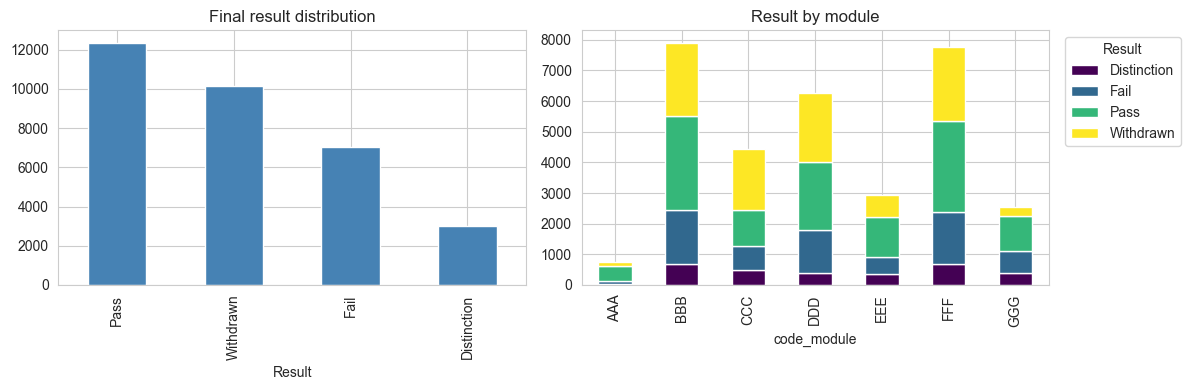

In [57]:
# Outcome distribution overall
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
student_info["final_result"].value_counts().plot(kind="bar", ax=axes[0], color="steelblue")
axes[0].set_title("Final result distribution")
axes[0].set_xlabel("Result")

# Per module
result_by_module = pd.crosstab(student_info["code_module"], student_info["final_result"])
result_by_module.plot(kind="bar", stacked=True, ax=axes[1], colormap="viridis")
axes[1].set_title("Result by module")
axes[1].legend(title="Result", bbox_to_anchor=(1.02, 1))
plt.tight_layout()
plt.show()

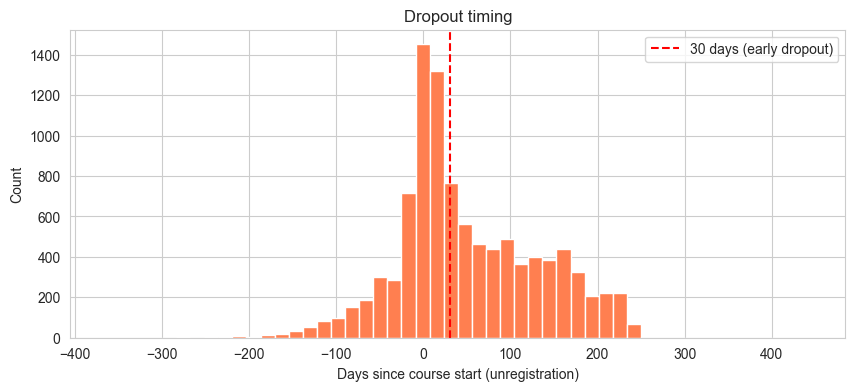

In [58]:
# Dropout timing: when in the course do students withdraw?
sr = student_registration.copy()
sr["date_unregistration"] = pd.to_numeric(sr["date_unregistration"], errors="coerce")
withdrawn = sr[sr["date_unregistration"].notna()]
plt.figure(figsize=(10, 4))
plt.hist(withdrawn["date_unregistration"].dropna(), bins=50, color="coral", edgecolor="white")
plt.axvline(30, color="red", linestyle="--", label="30 days (early dropout)")
plt.xlabel("Days since course start (unregistration)")
plt.ylabel("Count")
plt.title("Dropout timing")
plt.legend()
plt.show()

## Section 2 — Feature Engineering

Build per-student features: aggregated engagement, assessment behaviour, temporal/burnout signals, demographics.

In [59]:
# A. Aggregated engagement (per student per module-presentation)
# Merge VLE with activity types for forum_clicks
vle_forum = vle[vle["activity_type"] == "forumng"][["id_site", "code_module", "code_presentation"]].drop_duplicates()
sv_merged = student_vle.merge(vle_forum, on=["id_site", "code_module", "code_presentation"], how="left", indicator=True)
sv_merged["forum_click"] = (sv_merged["_merge"] == "both").astype(int) * sv_merged["sum_click"]

agg_vle = student_vle.groupby(["code_module", "code_presentation", "id_student"]).agg(
    total_clicks=("sum_click", "sum"),
    active_days=("date", "nunique"),
).reset_index()

forum_agg = sv_merged.groupby(["code_module", "code_presentation", "id_student"]).agg(
    forum_clicks=("forum_click", "sum"),
).reset_index()
agg_vle = agg_vle.merge(forum_agg, on=["code_module", "code_presentation", "id_student"], how="left")
agg_vle["forum_clicks"] = agg_vle["forum_clicks"].fillna(0)
agg_vle["login_freq_per_week"] = agg_vle["total_clicks"] / 38  # ~38 weeks
agg_vle["avg_session_intensity"] = np.where(agg_vle["active_days"] > 0, agg_vle["total_clicks"] / agg_vle["active_days"], 0)
print("Aggregated VLE (sample):")
print(agg_vle.head())

Aggregated VLE (sample):
  code_module code_presentation  id_student  total_clicks  active_days  \
0         AAA             2013J       11391           934           40   
1         AAA             2013J       28400          1435           80   
2         AAA             2013J       30268           281           12   
3         AAA             2013J       31604          2158          123   
4         AAA             2013J       32885          1034           70   

   forum_clicks  login_freq_per_week  avg_session_intensity  
0           193            24.578947              23.350000  
1           417            37.763158              17.937500  
2           126             7.394737              23.416667  
3           634            56.789474              17.544715  
4           194            27.210526              14.771429  


In [60]:
# B. Assessment behaviour: merge submissions with deadlines
assessments["date"] = pd.to_numeric(assessments["date"], errors="coerce")
student_assessment["date_submitted"] = pd.to_numeric(student_assessment["date_submitted"], errors="coerce")
student_assessment["score"] = pd.to_numeric(student_assessment["score"], errors="coerce")
sa_with_deadline = student_assessment.merge(
    assessments[["id_assessment", "code_module", "code_presentation", "date"]],
    on="id_assessment", how="left"
)
sa_with_deadline["days_late"] = sa_with_deadline["date_submitted"] - sa_with_deadline["date"]
sa_with_deadline["is_late"] = (sa_with_deadline["days_late"] > 0).astype(int)

assess_agg = sa_with_deadline.groupby(["code_module", "code_presentation", "id_student"]).agg(
    avg_score=("score", "mean"),
    min_score=("score", "min"),
    n_submissions=("id_assessment", "count"),
    late_count=("is_late", "sum"),
    avg_days_late=("days_late", lambda x: x[x > 0].mean()),
).reset_index()
assess_agg["late_sub_rate"] = assess_agg["late_count"] / assess_agg["n_submissions"]
assess_agg["avg_days_late"] = assess_agg["avg_days_late"].fillna(0)
# score_trend added in next cell
print("Assessment features (sample):")
print(assess_agg.head())

Assessment features (sample):
  code_module code_presentation  id_student  avg_score  min_score  \
0         AAA             2013J       11391       82.0       78.0   
1         AAA             2013J       28400       66.4       60.0   
2         AAA             2013J       31604       76.0       71.0   
3         AAA             2013J       32885       54.4       30.0   
4         AAA             2013J       38053       68.0       50.0   

   n_submissions  late_count  avg_days_late  late_sub_rate  
0              5           0            0.0            0.0  
1              5           2            3.5            0.4  
2              5           0            0.0            0.0  
3              5           5           11.4            1.0  
4              5           1           10.0            0.2  


In [61]:
# Simpler score trend: first half vs second half of submissions per student
sa_sorted = sa_with_deadline.sort_values(["code_module", "code_presentation", "id_student", "date_submitted"])
sa_sorted["rn"] = sa_sorted.groupby(["code_module", "code_presentation", "id_student"]).cumcount()
cnt = sa_sorted.groupby(["code_module", "code_presentation", "id_student"]).size().reset_index(name="total")
sa_sorted = sa_sorted.merge(cnt, on=["code_module", "code_presentation", "id_student"])
first_half = sa_sorted[sa_sorted["rn"] < sa_sorted["total"] // 2].groupby(["code_module", "code_presentation", "id_student"])["score"].mean().reset_index(name="early_avg")
second_half = sa_sorted[sa_sorted["rn"] >= sa_sorted["total"] // 2].groupby(["code_module", "code_presentation", "id_student"])["score"].mean().reset_index(name="late_avg")
trend = first_half.merge(second_half, on=["code_module", "code_presentation", "id_student"], how="outer")
trend["score_trend"] = trend["late_avg"].fillna(trend["early_avg"]) - trend["early_avg"].fillna(0)
assess_agg = assess_agg.drop(columns=["score_trend"], errors="ignore").merge(trend[["code_module", "code_presentation", "id_student", "score_trend"]], on=["code_module", "code_presentation", "id_student"], how="left")
assess_agg["score_trend"] = assess_agg["score_trend"].fillna(0)

In [62]:
# C. Temporal / burnout signals: weekly clicks, engagement decline, early_dropout
student_vle["week"] = (student_vle["date"] // 7).astype(int)
weekly = student_vle.groupby(["code_module", "code_presentation", "id_student", "week"])["sum_click"].sum().reset_index()
weeks_pivot = weekly.pivot_table(index=["code_module", "code_presentation", "id_student"], columns="week", values="sum_click", fill_value=0)

week_cols = [c for c in weeks_pivot.columns if isinstance(c, (int, np.integer))]
early_weeks = [w for w in week_cols if 0 <= w <= 4]
sorted_weeks = sorted(week_cols)
late_weeks = sorted_weeks[-4:] if len(sorted_weeks) >= 4 else sorted_weeks
weeks_pivot["clicks_first4"] = weeks_pivot[early_weeks].sum(axis=1) if early_weeks else 0
weeks_pivot["clicks_last4"] = weeks_pivot[[c for c in late_weeks if c in weeks_pivot.columns]].sum(axis=1) if late_weeks else 0
weeks_pivot["engagement_decline_rate"] = np.where(weeks_pivot["clicks_first4"] > 0,
    weeks_pivot["clicks_last4"] / weeks_pivot["clicks_first4"], 1.0)
weeks_pivot["peak_activity_week"] = weeks_pivot[week_cols].idxmax(axis=1) if week_cols else 0
weeks_pivot["activity_std"] = weeks_pivot[week_cols].std(axis=1).fillna(0)

temporal = weeks_pivot[["clicks_first4", "clicks_last4", "engagement_decline_rate", "peak_activity_week", "activity_std"]].reset_index()
temporal = temporal.rename(columns={"peak_activity_week": "peak_activity_week", "activity_std": "activity_std"})
print("Temporal features (sample):")
print(temporal.head())

Temporal features (sample):
week code_module code_presentation  id_student  clicks_first4  clicks_last4  \
0            AAA             2013J       11391          329.0           8.0   
1            AAA             2013J       28400          410.0           0.0   
2            AAA             2013J       30268          179.0           0.0   
3            AAA             2013J       31604          397.0          20.0   
4            AAA             2013J       32885          290.0           7.0   

week  engagement_decline_rate peak_activity_week  activity_std  
0                    0.024316                  0     36.421034  
1                    0.000000                  0     38.321338  
2                    0.000000                  0     23.266928  
3                    0.050378                  1     41.749968  
4                    0.024138                 -1     37.937262  


In [63]:
# Early dropout flag: unregistered within first 30 days
sr = student_registration.copy()
sr["date_unregistration"] = pd.to_numeric(sr["date_unregistration"], errors="coerce")
sr["early_dropout_flag"] = (sr["date_unregistration"].notna() & (sr["date_unregistration"] <= 30)).astype(int)
early_dropout = sr[["code_module", "code_presentation", "id_student", "early_dropout_flag"]]

# D. Demographics: IMD ordinal (0-10% = 10, 90-100% = 1 for deprivation risk)
imd_map = {"0-10%": 10, "10-20": 9, "20-30%": 8, "30-40%": 7, "40-50%": 6, "50-60%": 5, "60-70%": 4, "70-80%": 3, "80-90%": 2, "90-100%": 1, "?": np.nan}
student_info["imd_band_num"] = student_info["imd_band"].map(imd_map)
student_info["imd_band_num"] = student_info["imd_band_num"].fillna(student_info["imd_band_num"].median())

In [64]:
# Merge all features onto student_info (one row per enrolment)
df = student_info.copy()
df = df.merge(agg_vle, on=["code_module", "code_presentation", "id_student"], how="left")
df["has_vle_data"] = df["total_clicks"].notna().astype(int)
df = df.fillna({"total_clicks": 0, "active_days": 0, "forum_clicks": 0, "login_freq_per_week": 0, "avg_session_intensity": 0})
df = df.merge(assess_agg[["code_module", "code_presentation", "id_student", "avg_score", "min_score", "late_sub_rate", "avg_days_late", "score_trend"]],
              on=["code_module", "code_presentation", "id_student"], how="left")
df = df.merge(temporal[["code_module", "code_presentation", "id_student", "engagement_decline_rate", "peak_activity_week", "activity_std"]],
              on=["code_module", "code_presentation", "id_student"], how="left")
df = df.merge(early_dropout, on=["code_module", "code_presentation", "id_student"], how="left")
df["early_dropout_flag"] = df["early_dropout_flag"].fillna(0).astype(int)
df["engagement_decline_rate"] = df["engagement_decline_rate"].fillna(1.0)
df["peak_activity_week"] = df["peak_activity_week"].fillna(0)
df["activity_std"] = df["activity_std"].fillna(0)
df["avg_score"] = df["avg_score"].fillna(0)
df["late_sub_rate"] = df["late_sub_rate"].fillna(0)
df["avg_days_late"] = df["avg_days_late"].fillna(0)
print("Feature matrix shape:", df.shape)
print(df[["final_result", "total_clicks", "late_sub_rate", "engagement_decline_rate", "has_vle_data"]].head(10))

Feature matrix shape: (32593, 28)
  final_result  total_clicks  late_sub_rate  engagement_decline_rate  \
0         Pass         934.0            0.0                 0.024316   
1         Pass        1435.0            0.4                 0.000000   
2    Withdrawn         281.0            0.0                 0.000000   
3         Pass        2158.0            0.0                 0.050378   
4         Pass        1034.0            1.0                 0.024138   
5         Pass        2445.0            0.2                 0.080082   
6         Pass        1492.0            0.4                 0.009302   
7         Pass        1428.0            0.4                 0.048837   
8         Pass        1894.0            0.2                 0.007371   
9         Pass        3158.0            0.0                 0.063205   

   has_vle_data  
0             1  
1             1  
2             1  
3             1  
4             1  
5             1  
6             1  
7             1  
8          

## Section 3 — Label Engineering

Create targets: dropout (binary), at_risk (binary), burnout_risk (Low/Medium/High from k-Means).

In [65]:
# Dropout: Withdrawn=1, else=0. At-risk: Withdrawn or Fail=1, else=0
df["dropout"] = (df["final_result"] == "Withdrawn").astype(int)
df["at_risk"] = (df["final_result"].isin(["Withdrawn", "Fail"])).astype(int)

# Burnout risk level: k-Means on engagement_decline_rate, late_sub_rate, (1 - avg_score/100)
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
X_burnout = df[["engagement_decline_rate", "late_sub_rate", "avg_score"]].copy()
X_burnout["score_risk"] = 1 - X_burnout["avg_score"] / 100
X_burnout = X_burnout[["engagement_decline_rate", "late_sub_rate", "score_risk"]].fillna(0)
X_burnout_scaled = StandardScaler().fit_transform(X_burnout)
km = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_burnout_scaled)
df["_cluster"] = km.labels_
# Label clusters: high risk = high late_sub_rate, low engagement_decline_rate (dropped off)
cluster_means = df.groupby("_cluster")[["late_sub_rate", "engagement_decline_rate", "avg_score"]].mean()
cluster_means["risk_score"] = (1 - cluster_means["engagement_decline_rate"]) * 0.4 + cluster_means["late_sub_rate"] * 0.4 + (1 - cluster_means["avg_score"]/100) * 0.2
risk_order = cluster_means["risk_score"].rank().astype(int).to_dict()
df["burnout_risk"] = df["_cluster"].map({c: ["Low", "Medium", "High"][int(risk_order[c])-1] for c in risk_order})
df = df.drop(columns=["_cluster"])
print("Label distributions:")
for col in ["dropout", "at_risk", "burnout_risk"]:
    print(col, ":", df[col].value_counts().to_dict())

Label distributions:
dropout : {0: 22437, 1: 10156}
at_risk : {1: 17208, 0: 15385}
burnout_risk : {'Medium': 14771, 'High': 10788, 'Low': 7034}


## Section 4 — Module-Level & Socio-Economic Analysis

Withdrawal rate and engagement by module; IMD band vs outcome and behavioural metrics.

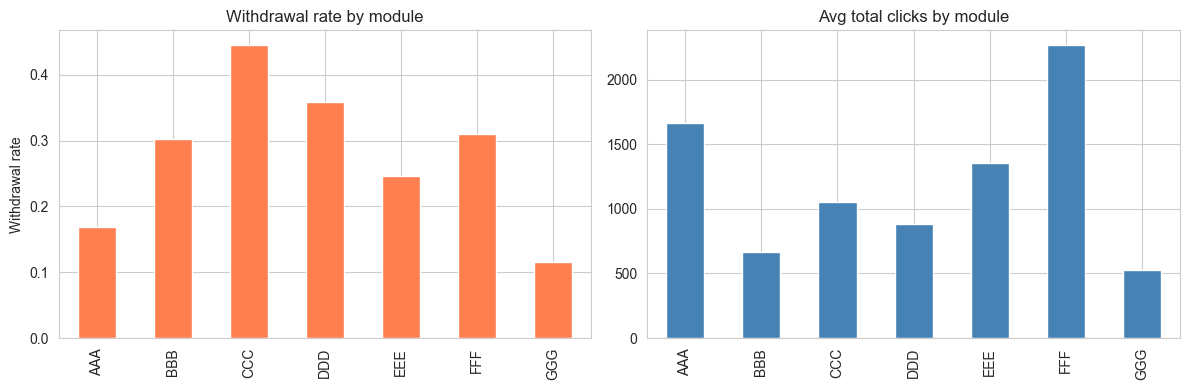

In [66]:
# Module-level: withdrawal rate and avg engagement
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
mod = df.groupby("code_module").agg(withdrawal_rate=("dropout", "mean"), avg_clicks=("total_clicks", "mean"), avg_late_rate=("late_sub_rate", "mean")).reset_index()
mod["withdrawal_rate"].plot(kind="bar", ax=axes[0], color="coral")
axes[0].set_xticklabels(mod["code_module"])
axes[0].set_title("Withdrawal rate by module")
axes[0].set_ylabel("Withdrawal rate")
mod["avg_clicks"].plot(kind="bar", ax=axes[1], color="steelblue")
axes[1].set_xticklabels(mod["code_module"])
axes[1].set_title("Avg total clicks by module")
plt.tight_layout()
plt.show()

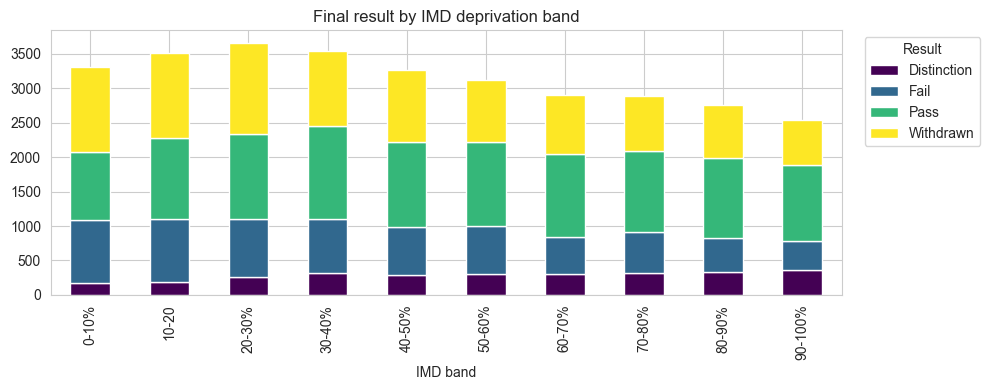

In [67]:
# IMD band vs final_result (stacked bar)
imd_result = pd.crosstab(df["imd_band"], df["final_result"])
imd_result = imd_result.reindex([k for k in imd_map if k != "?"])
imd_result.plot(kind="bar", stacked=True, figsize=(10, 4), colormap="viridis")
plt.title("Final result by IMD deprivation band")
plt.legend(title="Result", bbox_to_anchor=(1.02, 1))
plt.xlabel("IMD band")
plt.tight_layout()
plt.show()

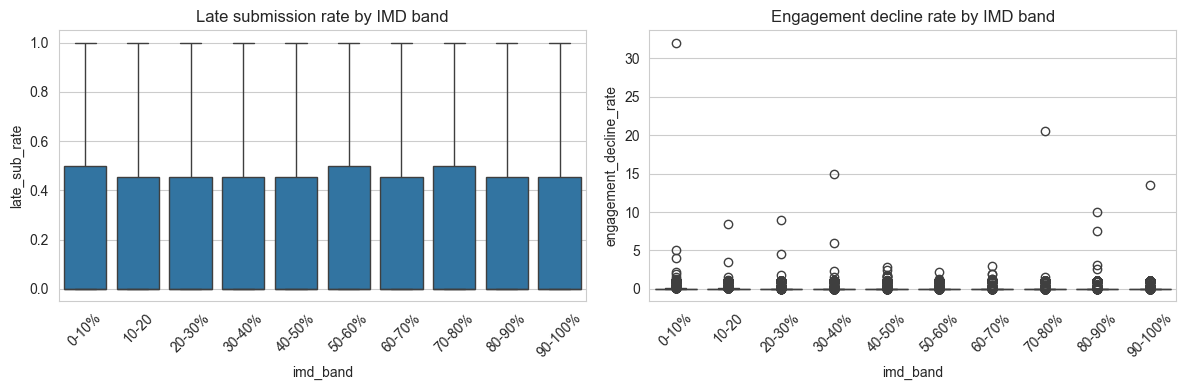

In [68]:
# IMD band vs late_sub_rate and engagement_decline_rate (box plots)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
df_imd = df[df["imd_band"].isin([k for k in imd_map if k != "?"])]
sns.boxplot(data=df_imd, x="imd_band", y="late_sub_rate", order=[k for k in imd_map if k != "?"], ax=axes[0])
axes[0].tick_params(axis="x", rotation=45)
axes[0].set_title("Late submission rate by IMD band")
sns.boxplot(data=df_imd, x="imd_band", y="engagement_decline_rate", order=[k for k in imd_map if k != "?"], ax=axes[1])
axes[1].tick_params(axis="x", rotation=45)
axes[1].set_title("Engagement decline rate by IMD band")
plt.tight_layout()
plt.show()

## Section 5 — Temporal Burnout Analysis

Engagement trajectories by outcome; student x week heatmap; engagement decline distribution.

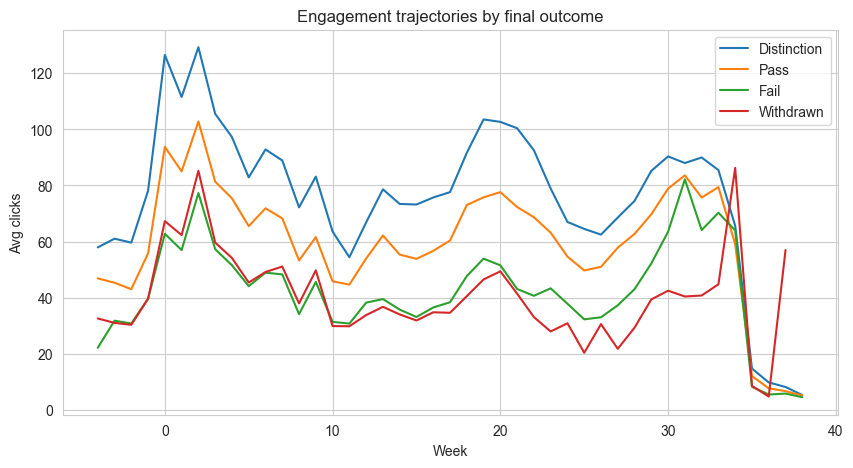

In [69]:
# Average weekly clicks by final outcome (merge weekly with student_info for result)
weekly_with_result = weekly.merge(student_info[["code_module", "code_presentation", "id_student", "final_result"]],
    on=["code_module", "code_presentation", "id_student"], how="inner")
traj = weekly_with_result.groupby(["final_result", "week"])["sum_click"].mean().reset_index()
plt.figure(figsize=(10, 5))
for result in ["Distinction", "Pass", "Fail", "Withdrawn"]:
    d = traj[traj["final_result"] == result]
    plt.plot(d["week"], d["sum_click"], label=result)
plt.xlabel("Week")
plt.ylabel("Avg clicks")
plt.title("Engagement trajectories by final outcome")
plt.legend()
plt.show()

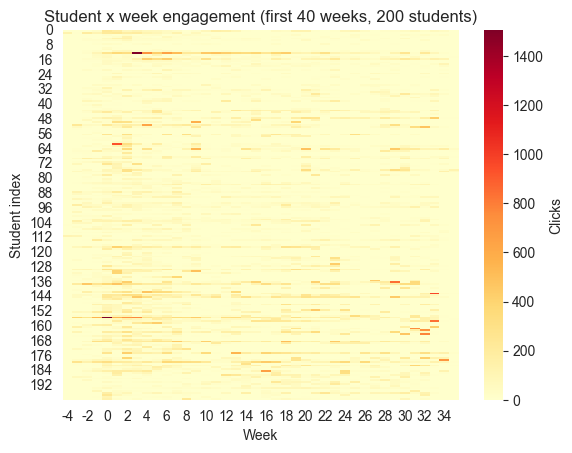

In [70]:
# Heatmap: student x week engagement (sample of 200 students)
np.random.seed(42)
sample_ids = weekly_with_result[["code_module", "code_presentation", "id_student"]].drop_duplicates().sample(n=min(200, weekly_with_result[["code_module", "code_presentation", "id_student"]].drop_duplicates().shape[0]))
weekly_sample = weekly_with_result.merge(sample_ids, on=["code_module", "code_presentation", "id_student"])
heatmap_data = weekly_sample.pivot_table(index=["code_module", "code_presentation", "id_student"], columns="week", values="sum_click", fill_value=0)
# Single index for display
heatmap_data.index = range(len(heatmap_data))
sns.heatmap(heatmap_data.iloc[:, :40], cmap="YlOrRd", cbar_kws={"label": "Clicks"})
plt.title("Student x week engagement (first 40 weeks, 200 students)")
plt.xlabel("Week")
plt.ylabel("Student index")
plt.show()

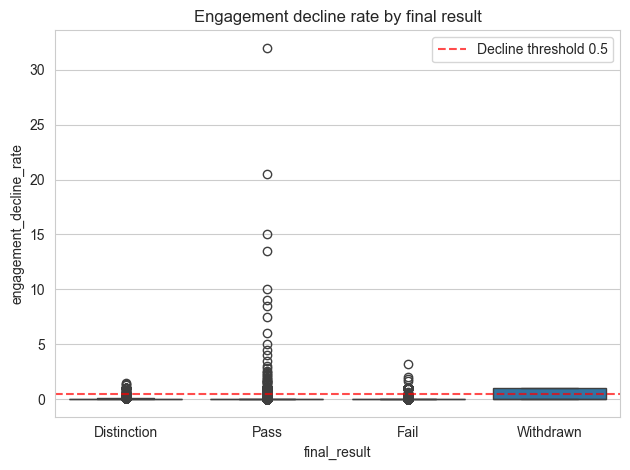

In [71]:
# Distribution of engagement_decline_rate by outcome group
sns.boxplot(data=df, x="final_result", y="engagement_decline_rate", order=["Distinction", "Pass", "Fail", "Withdrawn"])
plt.title("Engagement decline rate by final result")
plt.axhline(0.5, color="red", linestyle="--", alpha=0.7, label="Decline threshold 0.5")
plt.legend()
plt.tight_layout()
plt.show()

## Section 6 — Early Prediction (4-Week Model)

Use only features from first 4 weeks (days 0–28). Random Forest predicting dropout. Report Accuracy, Precision, Recall, F1, ROC-AUC; feature importance.

In [72]:
# Build 4-week features: VLE clicks and active days in first 28 days
student_vle["in_first4"] = (student_vle["date"] >= 0) & (student_vle["date"] <= 28)
early_vle = student_vle[student_vle["in_first4"]].groupby(["code_module", "code_presentation", "id_student"]).agg(
    clicks_wk1_4=("sum_click", "sum"),
    active_days_wk1_4=("date", "nunique"),
).reset_index()
# Submissions in first 4 weeks
sa_with_deadline["in_first4"] = (sa_with_deadline["date_submitted"] >= 0) & (sa_with_deadline["date_submitted"] <= 28)
early_sub = sa_with_deadline[sa_with_deadline["in_first4"]].groupby(["code_module", "code_presentation", "id_student"]).agg(
    submissions_wk1_4=("id_assessment", "count"),
    early_scores_avg=("score", "mean"),
).reset_index()
early_features = early_vle.merge(early_sub, on=["code_module", "code_presentation", "id_student"], how="outer")
early_features = early_features.fillna(0)
df_early = df[["code_module", "code_presentation", "id_student", "dropout", "imd_band_num", "num_of_prev_attempts", "studied_credits"]].merge(
    early_features, on=["code_module", "code_presentation", "id_student"], how="left"
).fillna(0)
FEAT_EARLY = ["clicks_wk1_4", "active_days_wk1_4", "submissions_wk1_4", "early_scores_avg", "imd_band_num", "num_of_prev_attempts", "studied_credits"]
X_early = df_early[FEAT_EARLY]
y_early = df_early["dropout"]
print("4-week feature matrix shape:", X_early.shape)

4-week feature matrix shape: (32593, 7)


In [73]:
# Train Random Forest, 70/30 split, stratify
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve

X_tr, X_te, y_tr, y_te = train_test_split(X_early, y_early, test_size=0.3, random_state=42, stratify=y_early)
rf_early = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_early.fit(X_tr, y_tr)
y_pred = rf_early.predict(X_te)
y_proba = rf_early.predict_proba(X_te)[:, 1]
print("4-Week Early Prediction (Dropout):")
print(f"  Accuracy:  {accuracy_score(y_te, y_pred):.4f}")
print(f"  Precision: {precision_score(y_te, y_pred, zero_division=0):.4f}")
print(f"  Recall:   {recall_score(y_te, y_pred, zero_division=0):.4f}")
print(f"  F1:       {f1_score(y_te, y_pred, zero_division=0):.4f}")
print(f"  ROC-AUC:  {roc_auc_score(y_te, y_proba):.4f}")
scores = cross_val_score(rf_early, X_early, y_early, cv=10, scoring="accuracy")
print(f"  10-fold CV Accuracy: {scores.mean():.4f} (+/- {scores.std()*2:.4f})")

4-Week Early Prediction (Dropout):
  Accuracy:  0.7947
  Precision: 0.7697
  Recall:   0.4870
  F1:       0.5966
  ROC-AUC:  0.8124
  10-fold CV Accuracy: 0.7527 (+/- 0.1622)


**Improving F1:** Resampling (bootstrap oversample of minority class), `class_weight='balanced'`, XGBoost with `scale_pos_weight`, and MLP. Best model is used for ROC and feature importance below.

In [74]:
# Improve prediction: resampling, class_weight, XGBoost, MLP
from sklearn.utils import resample
from sklearn.neural_network import MLPClassifier

# 1) Oversample minority (bootstrap): resample dropout=1 to match dropout=0 count in training set
idx_min = y_tr[y_tr == 1].index
idx_maj = y_tr[y_tr == 0].index
n_maj = len(idx_maj)
idx_min_upsampled = resample(idx_min, replace=True, n_samples=n_maj, random_state=42)
idx_train_bal = np.concatenate([idx_maj, idx_min_upsampled])
rng = np.random.RandomState(42)
rng.shuffle(idx_train_bal)
X_tr_bal = X_tr.loc[idx_train_bal]
y_tr_bal = y_tr.loc[idx_train_bal]

# 2) Random Forest with class_weight='balanced' (no resampling)
rf_balanced = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight="balanced")
rf_balanced.fit(X_tr, y_tr)
pred_bal = rf_balanced.predict(X_te)
print("RF (class_weight=balanced):", "F1 =", f1_score(y_te, pred_bal, zero_division=0))

# 3) RF on resampled (bootstrapped) training data
rf_resampled = RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10)
rf_resampled.fit(X_tr_bal, y_tr_bal)
pred_rs = rf_resampled.predict(X_te)
print("RF (resampled train):      ", "F1 =", f1_score(y_te, pred_rs, zero_division=0))

# 4) XGBoost with scale_pos_weight (skip if library fails, e.g. missing libomp on Mac)
f1_xgb = -1.0
try:
    import xgboost as xgb
    scale_pos = (y_tr == 0).sum() / max((y_tr == 1).sum(), 1)
    xgb_early = xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, scale_pos_weight=scale_pos, use_label_encoder=False, eval_metric="logloss")
    xgb_early.fit(X_tr, y_tr)
    pred_xgb = xgb_early.predict(X_te)
    y_proba_xgb = xgb_early.predict_proba(X_te)[:, 1]
    f1_xgb = f1_score(y_te, pred_xgb, zero_division=0)
    print("XGBoost (scale_pos_weight): ", "F1 =", f1_xgb)
except Exception as e:
    print("XGBoost skipped (install libomp on Mac: brew install libomp):", type(e).__name__)

# 5) MLP (advanced supervised: neural net for tabular data)
f1_mlp = -1.0
try:
    scaler_early = StandardScaler()
    X_tr_s = scaler_early.fit_transform(X_tr)
    X_te_s = scaler_early.transform(X_te)
    mlp_early = MLPClassifier(hidden_layer_sizes=(64, 32), max_iter=200, random_state=42, early_stopping=True)
    mlp_early.fit(X_tr_s, y_tr)
    pred_mlp = mlp_early.predict(X_te_s)
    f1_mlp = f1_score(y_te, pred_mlp, zero_division=0)
    print("MLPClassifier:              ", "F1 =", f1_mlp)
except Exception as e:
    print("MLPClassifier skipped:", type(e).__name__)

# Pick best F1 for dashboard (among models that ran)
f1_rf_bal = f1_score(y_te, pred_bal, zero_division=0)
f1_rf_rs = f1_score(y_te, pred_rs, zero_division=0)
best_f1 = max(f1_rf_bal, f1_rf_rs, f1_xgb, f1_mlp)
if f1_xgb >= best_f1 and f1_xgb >= 0:
    y_proba = y_proba_xgb
    fpr_early, tpr_early, _ = roc_curve(y_te, y_proba)
    roc_auc_early = roc_auc_score(y_te, y_proba)
    rf_early = xgb_early
else:
    y_proba = rf_balanced.predict_proba(X_te)[:, 1]
    fpr_early, tpr_early, _ = roc_curve(y_te, y_proba)
    roc_auc_early = roc_auc_score(y_te, y_proba)
    rf_early = rf_balanced
print("\nBest early model F1:", best_f1)

RF (class_weight=balanced): F1 = 0.6401219925449
RF (resampled train):       F1 = 0.6404172976611139
XGBoost skipped (install libomp on Mac: brew install libomp): XGBoostError
MLPClassifier:               F1 = 0.5985997666277713

Best early model F1: 0.6404172976611139


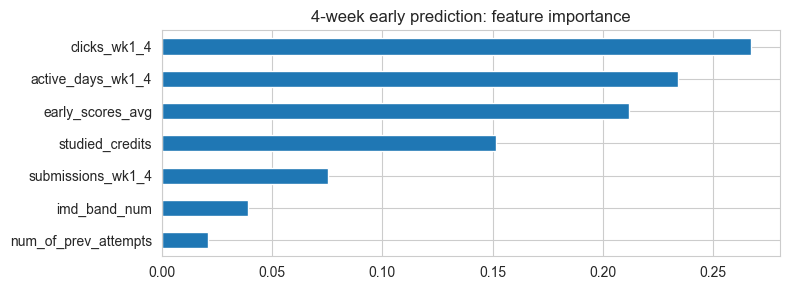

In [75]:
# Feature importance (4-week model)
imp = pd.Series(rf_early.feature_importances_, index=FEAT_EARLY).sort_values(ascending=True)
imp.plot(kind="barh", figsize=(8, 3))
plt.title("4-week early prediction: feature importance")
plt.tight_layout()
plt.show()
# Store for dashboard
fpr_early, tpr_early, _ = roc_curve(y_te, y_proba)
roc_auc_early = roc_auc_score(y_te, y_proba)

## Section 7 — Full-Course Predictive Models

Random Forest and Decision Tree (C4.5-style), Naive Bayes for at_risk; k-Means (k=3) for cluster profiles. Metrics table.

In [76]:
# Feature set for full-course models (numeric only)
FEAT_FULL = ["total_clicks", "active_days", "forum_clicks", "login_freq_per_week", "avg_session_intensity",
             "avg_score", "min_score", "late_sub_rate", "avg_days_late", "score_trend",
             "engagement_decline_rate", "peak_activity_week", "activity_std", "early_dropout_flag",
             "imd_band_num", "num_of_prev_attempts", "studied_credits"]
df_model = df.dropna(subset=FEAT_FULL + ["at_risk"])
X_full = df_model[FEAT_FULL]
y_at_risk = df_model["at_risk"]
X_train, X_test, y_train, y_test = train_test_split(X_full, y_at_risk, test_size=0.3, random_state=42, stratify=y_at_risk)

In [77]:
# Random Forest (with class_weight), Decision Tree, Naive Bayes, XGBoost
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42, max_depth=10, class_weight="balanced"),
    "Decision Tree": DecisionTreeClassifier(max_depth=5, random_state=42, class_weight="balanced"),
    "Naive Bayes": GaussianNB(),
}
metrics_list = []
for name, m in models.items():
    X_tr, X_te = (X_train_s, X_test_s) if name == "Naive Bayes" else (X_train, X_test)
    m.fit(X_tr, y_train)
    pred = m.predict(X_te)
    metrics_list.append({
        "Model": name,
        "Accuracy": accuracy_score(y_test, pred),
        "Precision": precision_score(y_test, pred, zero_division=0),
        "Recall": recall_score(y_test, pred, zero_division=0),
        "F1": f1_score(y_test, pred, zero_division=0),
    })
# XGBoost with scale_pos_weight for at_risk imbalance (skip if library fails)
try:
    import xgboost as xgb
    scale_pos_full = (y_train == 0).sum() / max((y_train == 1).sum(), 1)
    xgb_full = xgb.XGBClassifier(n_estimators=100, max_depth=6, random_state=42, scale_pos_weight=scale_pos_full, use_label_encoder=False, eval_metric="logloss")
    xgb_full.fit(X_train, y_train)
    pred_xgb = xgb_full.predict(X_test)
    metrics_list.append({
        "Model": "XGBoost",
        "Accuracy": accuracy_score(y_test, pred_xgb),
        "Precision": precision_score(y_test, pred_xgb, zero_division=0),
        "Recall": recall_score(y_test, pred_xgb, zero_division=0),
        "F1": f1_score(y_test, pred_xgb, zero_division=0),
    })
except Exception as e:
    print("XGBoost skipped for full-course:", type(e).__name__)
metrics_df = pd.DataFrame(metrics_list)
print("Full-course at_risk prediction — metrics:")
print(metrics_df.to_string(index=False))
# Keep RF and DT for later
rf_full = models["Random Forest"]
dt_full = models["Decision Tree"]

XGBoost skipped for full-course: XGBoostError
Full-course at_risk prediction — metrics:
        Model  Accuracy  Precision   Recall       F1
Random Forest  0.865995   0.830648 0.839668 0.835133
Decision Tree  0.831784   0.786880 0.800703 0.793731
  Naive Bayes  0.729796   0.936869 0.355477 0.515397


In [78]:
# k-Means (k=3): cluster profiles
X_k = df_model[["engagement_decline_rate", "late_sub_rate", "avg_score", "total_clicks"]].fillna(0)
X_k_scaled = StandardScaler().fit_transform(X_k)
km_full = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_k_scaled)
df_model = df_model.copy()
df_model["cluster"] = km_full.labels_
# Label clusters by mean at_risk and engagement
cluster_profile = df_model.groupby("cluster")[["at_risk", "total_clicks", "late_sub_rate", "engagement_decline_rate"]].mean()
cluster_profile["label"] = ["Low engagement", "Average", "High engagement"][:3]  # refine by sort
print("k-Means cluster profiles:")
print(cluster_profile)

k-Means cluster profiles:
          at_risk  total_clicks  late_sub_rate  engagement_decline_rate  \
cluster                                                                   
0        0.509228    834.411776       0.635321                 0.025244   
1        0.421133   1042.318343       0.058289                 0.049059   
2        0.064284   4907.621232       0.134046                 0.020743   

                   label  
cluster                   
0         Low engagement  
1                Average  
2        High engagement  


## Section 8 — Risk Score Engine (0–100)

Weighted composite: engagement decline (30%), late submission (25%), low score (25%), forum absence (10%), socioeconomic (10%). Output risk_score and burnout_risk_level (Low &lt;33, Medium 33–66, High &gt;66).

In [79]:
# Normalize components to 0-100 scale then weight
# engagement_decline: low rate = high risk -> weight = (1 - min(rate, 1)) * 100
# late_sub_rate: already 0-1 -> * 100
# low_score: (100 - avg_score) or (1 - avg_score/100) * 100
# forum_absence: 1 if forum_clicks==0 else 0 -> * 100
# socioeconomic: higher deprivation = higher risk; imd_band_num 1-10 -> (10 - imd_band_num)/9 * 100 for "risk", or use imd as is
def risk_components(d):
    eng_w = (1 - np.minimum(d["engagement_decline_rate"].fillna(1), 1)) * 100  # decline = risk
    late_w = d["late_sub_rate"].fillna(0) * 100
    score_w = (100 - d["avg_score"].fillna(50))  # low score = high risk
    score_w = np.clip(score_w, 0, 100)
    forum_w = (d["forum_clicks"].fillna(0) == 0).astype(int) * 100
    # IMD: higher band number = less deprived in our map (0-10% = 10). So risk = (10 - imd)/10 * 100
    imd = d["imd_band_num"].fillna(5)
    socio_w = (10 - imd) / 10 * 100
    socio_w = np.clip(socio_w, 0, 100)
    return eng_w, late_w, score_w, forum_w, socio_w

e, l, s, f, i = risk_components(df)
df["risk_score"] = e * 0.30 + l * 0.25 + s * 0.25 + f * 0.10 + i * 0.10
df["risk_score"] = np.clip(df["risk_score"], 0, 100)
df["burnout_risk_level"] = pd.cut(df["risk_score"], bins=[-0.01, 33, 66, 100], labels=["Low", "Medium", "High"])
print("Risk score stats:")
print(df["risk_score"].describe())
print(df["burnout_risk_level"].value_counts())

Risk score stats:
count    32593.000000
mean        48.214268
std         11.478189
min          2.125000
25%         39.538312
50%         45.937500
75%         55.975000
max         98.000000
Name: risk_score, dtype: float64
burnout_risk_level
Medium    29116
High       2549
Low         928
Name: count, dtype: int64


## Section 9 — Behavioural Triggers & Interventions

Rule-based trigger tagging and recommended intervention per student.

In [80]:
# Triggers and interventions
df["trigger_disengagement"] = (df["engagement_decline_rate"] < 0.5).astype(int)
df["trigger_deadline_avoidance"] = (df["late_sub_rate"] > 0.4).astype(int)
df["trigger_content_avoidance"] = (df["forum_clicks"] == 0).astype(int)
df["trigger_score_deterioration"] = (df["score_trend"] < -10).astype(int)
df["trigger_early_dropout_risk"] = (df["early_dropout_flag"] == 1).astype(int)

def recommend_intervention(row):
    recs = []
    if row["trigger_disengagement"]: recs.append("Personal outreach + study plan review")
    if row["trigger_deadline_avoidance"]: recs.append("Time management workshop")
    if row["trigger_content_avoidance"]: recs.append("Peer learning / tutor introduction")
    if row["trigger_score_deterioration"]: recs.append("Academic support / tutoring referral")
    if row["trigger_early_dropout_risk"]: recs.append("Immediate advisor contact")
    return "; ".join(recs) if recs else "Monitor"

df["recommended_intervention"] = df.apply(recommend_intervention, axis=1)
print("Trigger counts:")
print(df[["trigger_disengagement", "trigger_deadline_avoidance", "trigger_content_avoidance", "trigger_score_deterioration", "trigger_early_dropout_risk"]].sum())
print("\\nSample recommendations:")
print(df[["risk_score", "burnout_risk_level", "recommended_intervention"]].head(10).to_string())

Trigger counts:
trigger_disengagement          27958
trigger_deadline_avoidance     10226
trigger_content_avoidance       6587
trigger_score_deterioration     6660
trigger_early_dropout_risk      5127
dtype: int64
\nSample recommendations:
   risk_score burnout_risk_level                                          recommended_intervention
0   42.770517             Medium                             Personal outreach + study plan review
1   50.400000             Medium                             Personal outreach + study plan review
2   58.000000             Medium  Personal outreach + study plan review; Immediate advisor contact
3   39.488665             Medium                             Personal outreach + study plan review
4   70.675862               High   Personal outreach + study plan review; Time management workshop
5   48.597536             Medium                             Personal outreach + study plan review
6   50.720930             Medium                             Person

## Section 10 — Visualisation Dashboard

Multi-panel summary: outcome distribution, dropout timing, module withdrawal, trajectories, heatmap, risk score, feature importance, IMD vs risk, k-Means clusters, 4-week ROC curve.

## Export models for web app

Run this cell **after** running all cells above. It saves the trained models and metadata so the interactive frontend can run predictions.

In [81]:
# Export models and config for the interactive frontend (run after all cells above)
import json
import joblib
from pathlib import Path

EXPORT_DIR = Path("webapp_artifacts")
EXPORT_DIR.mkdir(exist_ok=True)

# Save 4-week (early dropout) and full-course (at_risk) models
joblib.dump(rf_early, EXPORT_DIR / "model_early_dropout.joblib")
joblib.dump(rf_full, EXPORT_DIR / "model_full_at_risk.joblib")

# Risk score and intervention logic (reproduced in backend from these params)
config = {
    "FEAT_EARLY": FEAT_EARLY,
    "FEAT_FULL": FEAT_FULL,
    "risk_weights": {"engagement_decline": 0.30, "late_sub": 0.25, "score": 0.25, "forum_absence": 0.10, "socio": 0.10},
    "burnout_bins": [0, 33, 66, 100],
    "trigger_thresholds": {
        "disengagement": {"engagement_decline_rate": 0.5, "op": "<"},
        "deadline_avoidance": {"late_sub_rate": 0.4, "op": ">"},
        "content_avoidance": {"forum_clicks": 0, "op": "=="},
        "score_deterioration": {"score_trend": -10, "op": "<"},
        "early_dropout_risk": {"early_dropout_flag": 1, "op": "=="},
    },
    "interventions": {
        "trigger_disengagement": "Personal outreach + study plan review",
        "trigger_deadline_avoidance": "Time management workshop",
        "trigger_content_avoidance": "Peer learning / tutor introduction",
        "trigger_score_deterioration": "Academic support / tutoring referral",
        "trigger_early_dropout_risk": "Immediate advisor contact",
    },
    "imd_band_map": {"0-10%": 10, "10-20": 9, "20-30%": 8, "30-40%": 7, "40-50%": 6, "50-60%": 5, "60-70%": 4, "70-80%": 3, "80-90%": 2, "90-100%": 1},
}
with open(EXPORT_DIR / "config.json", "w") as f:
    json.dump(config, f, indent=2)

print("Exported to", EXPORT_DIR)
print("  model_early_dropout.joblib, model_full_at_risk.joblib, config.json")

Exported to webapp_artifacts
  model_early_dropout.joblib, model_full_at_risk.joblib, config.json


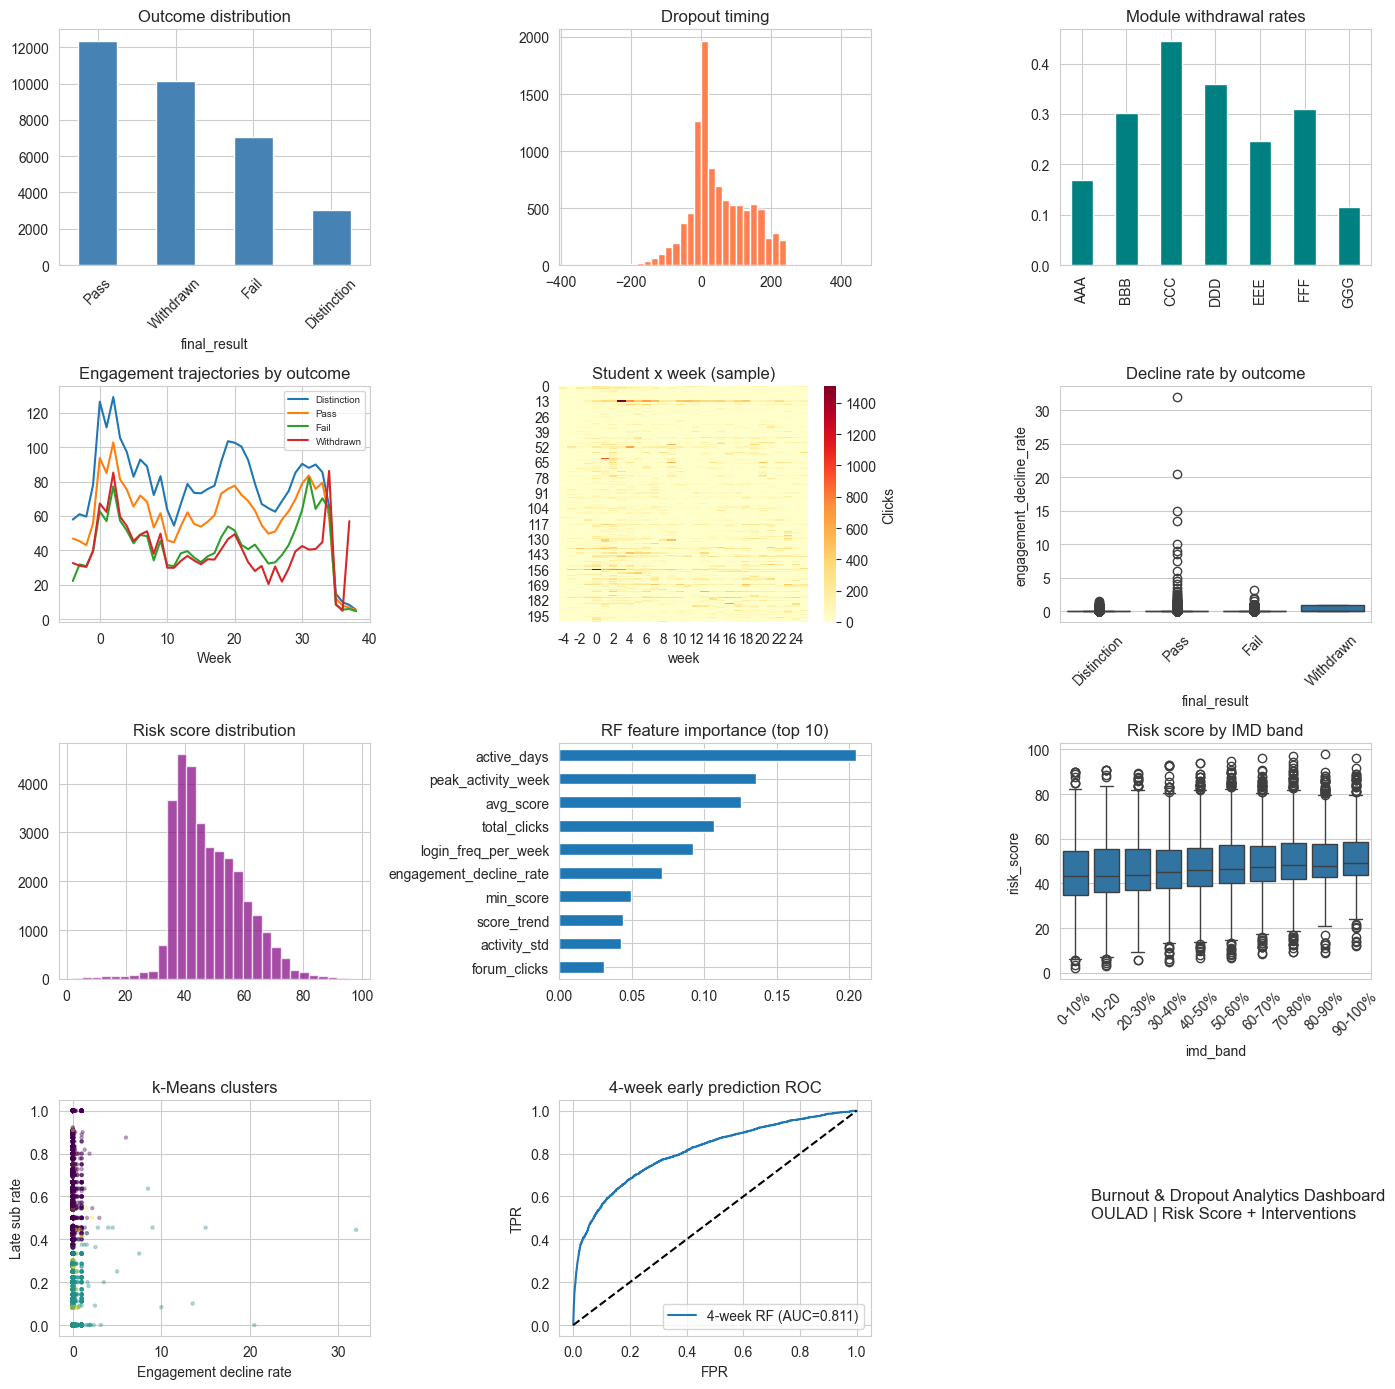

In [82]:
# Dashboard: 4x3 grid
fig, axes = plt.subplots(4, 3, figsize=(14, 14))

# Row 1: outcome dist, dropout timing, module withdrawal
student_info["final_result"].value_counts().plot(kind="bar", ax=axes[0, 0], color="steelblue")
axes[0, 0].set_title("Outcome distribution")
axes[0, 0].tick_params(axis="x", rotation=45)
withdrawn = student_registration.copy()
withdrawn["date_unregistration"] = pd.to_numeric(withdrawn["date_unregistration"], errors="coerce")
withdrawn = withdrawn[withdrawn["date_unregistration"].notna()]
axes[0, 1].hist(withdrawn["date_unregistration"], bins=40, color="coral", edgecolor="white")
axes[0, 1].set_title("Dropout timing")
mod["withdrawal_rate"].plot(kind="bar", ax=axes[0, 2], color="teal")
axes[0, 2].set_xticklabels(mod["code_module"])
axes[0, 2].set_title("Module withdrawal rates")

# Row 2: trajectories by outcome, heatmap (small), engagement decline by outcome
for result in ["Distinction", "Pass", "Fail", "Withdrawn"]:
    d = traj[traj["final_result"] == result]
    axes[1, 0].plot(d["week"], d["sum_click"], label=result)
axes[1, 0].set_title("Engagement trajectories by outcome")
axes[1, 0].legend(fontsize=7)
axes[1, 0].set_xlabel("Week")
sns.heatmap(heatmap_data.iloc[:, :30], cmap="YlOrRd", ax=axes[1, 1], cbar_kws={"label": "Clicks"})
axes[1, 1].set_title("Student x week (sample)")
sns.boxplot(data=df, x="final_result", y="engagement_decline_rate", order=["Distinction", "Pass", "Fail", "Withdrawn"], ax=axes[1, 2])
axes[1, 2].tick_params(axis="x", rotation=45)
axes[1, 2].set_title("Decline rate by outcome")

# Row 3: risk score dist, feature importance (full model), IMD vs risk
axes[2, 0].hist(df["risk_score"], bins=30, color="purple", alpha=0.7, edgecolor="white")
axes[2, 0].set_title("Risk score distribution")
imp_full = pd.Series(rf_full.feature_importances_, index=FEAT_FULL).sort_values(ascending=True).tail(10)
imp_full.plot(kind="barh", ax=axes[2, 1])
axes[2, 1].set_title("RF feature importance (top 10)")
sns.boxplot(data=df, x="imd_band", y="risk_score", ax=axes[2, 2], order=[k for k in imd_map if k != "?"])
axes[2, 2].set_title("Risk score by IMD band")
axes[2, 2].tick_params(axis="x", rotation=45)

# Row 4: k-Means scatter, 4-week ROC
axes[3, 0].scatter(df_model["engagement_decline_rate"], df_model["late_sub_rate"], c=df_model["cluster"], cmap="viridis", alpha=0.3, s=5)
axes[3, 0].set_xlabel("Engagement decline rate")
axes[3, 0].set_ylabel("Late sub rate")
axes[3, 0].set_title("k-Means clusters")
axes[3, 1].plot(fpr_early, tpr_early, label=f"4-week RF (AUC={roc_auc_early:.3f})")
axes[3, 1].plot([0, 1], [0, 1], "k--")
axes[3, 1].set_xlabel("FPR")
axes[3, 1].set_ylabel("TPR")
axes[3, 1].set_title("4-week early prediction ROC")
axes[3, 1].legend()
axes[3, 2].axis("off")
axes[3, 2].text(0.1, 0.5, "Burnout & Dropout Analytics Dashboard\nOULAD | Risk Score + Interventions", fontsize=12)
plt.tight_layout()
plt.show()

In [ ]:
# Export all visualizations to webapp_artifacts/viz/ for frontend "See detailed results" modal
VIZ_DIR = Path("webapp_artifacts/viz")
VIZ_DIR.mkdir(parents=True, exist_ok=True)

# Reuse withdrawn for exports
withdrawn_viz = student_registration.copy()
withdrawn_viz["date_unregistration"] = pd.to_numeric(withdrawn_viz["date_unregistration"], errors="coerce")
withdrawn_viz = withdrawn_viz[withdrawn_viz["date_unregistration"].notna()]

# 1) Full dashboard (4x3 summary)
fig, axes = plt.subplots(4, 3, figsize=(14, 14))
student_info["final_result"].value_counts().plot(kind="bar", ax=axes[0, 0], color="steelblue")
axes[0, 0].set_title("Outcome distribution")
axes[0, 0].tick_params(axis="x", rotation=45)
axes[0, 1].hist(withdrawn_viz["date_unregistration"], bins=40, color="coral", edgecolor="white")
axes[0, 1].set_title("Dropout timing")
mod["withdrawal_rate"].plot(kind="bar", ax=axes[0, 2], color="teal")
axes[0, 2].set_xticklabels(mod["code_module"])
axes[0, 2].set_title("Module withdrawal rates")
for result in ["Distinction", "Pass", "Fail", "Withdrawn"]:
    d = traj[traj["final_result"] == result]
    axes[1, 0].plot(d["week"], d["sum_click"], label=result)
axes[1, 0].set_title("Engagement trajectories by outcome")
axes[1, 0].legend(fontsize=7)
axes[1, 0].set_xlabel("Week")
sns.heatmap(heatmap_data.iloc[:, :30], cmap="YlOrRd", ax=axes[1, 1], cbar_kws={"label": "Clicks"})
axes[1, 1].set_title("Student x week (sample)")
sns.boxplot(data=df, x="final_result", y="engagement_decline_rate", order=["Distinction", "Pass", "Fail", "Withdrawn"], ax=axes[1, 2])
axes[1, 2].tick_params(axis="x", rotation=45)
axes[1, 2].set_title("Decline rate by outcome")
axes[2, 0].hist(df["risk_score"], bins=30, color="purple", alpha=0.7, edgecolor="white")
axes[2, 0].set_title("Risk score distribution")
imp_exp = pd.Series(rf_full.feature_importances_, index=FEAT_FULL).sort_values(ascending=True).tail(10)
imp_exp.plot(kind="barh", ax=axes[2, 1])
axes[2, 1].set_title("RF feature importance (top 10)")
sns.boxplot(data=df, x="imd_band", y="risk_score", ax=axes[2, 2], order=[k for k in imd_map if k != "?"])
axes[2, 2].set_title("Risk score by IMD band")
axes[2, 2].tick_params(axis="x", rotation=45)
axes[3, 0].scatter(df_model["engagement_decline_rate"], df_model["late_sub_rate"], c=df_model["cluster"], cmap="viridis", alpha=0.3, s=5)
axes[3, 0].set_xlabel("Engagement decline rate")
axes[3, 0].set_ylabel("Late sub rate")
axes[3, 0].set_title("k-Means clusters")
axes[3, 1].plot(fpr_early, tpr_early, label=f"4-week RF (AUC={roc_auc_early:.3f})")
axes[3, 1].plot([0, 1], [0, 1], "k--")
axes[3, 1].set_xlabel("FPR")
axes[3, 1].set_ylabel("TPR")
axes[3, 1].set_title("4-week early prediction ROC")
axes[3, 1].legend()
axes[3, 2].axis("off")
axes[3, 2].text(0.1, 0.5, "Burnout & Dropout Analytics Dashboard\nOULAD | Risk Score + Interventions", fontsize=12)
plt.tight_layout()
fig.savefig(VIZ_DIR / "dashboard_summary.png", dpi=120, bbox_inches="tight")
plt.close()

# 2) Individual figures for modal
fig, ax = plt.subplots(figsize=(6, 4))
student_info["final_result"].value_counts().plot(kind="bar", ax=ax, color="steelblue")
ax.set_title("Outcome distribution")
ax.tick_params(axis="x", rotation=45)
fig.savefig(VIZ_DIR / "dataset_outcome_distribution.png", dpi=120, bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(withdrawn_viz["date_unregistration"], bins=40, color="coral", edgecolor="white")
ax.set_title("Dropout timing")
ax.set_xlabel("Days since course start")
fig.savefig(VIZ_DIR / "dataset_dropout_timing.png", dpi=120, bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(figsize=(6, 4))
mod["withdrawal_rate"].plot(kind="bar", ax=ax, color="teal")
ax.set_xticklabels(mod["code_module"])
ax.set_title("Module withdrawal rates")
fig.savefig(VIZ_DIR / "dataset_module_withdrawal.png", dpi=120, bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(figsize=(7, 4))
for result in ["Distinction", "Pass", "Fail", "Withdrawn"]:
    d = traj[traj["final_result"] == result]
    ax.plot(d["week"], d["sum_click"], label=result)
ax.set_title("Engagement trajectories by outcome")
ax.legend()
ax.set_xlabel("Week")
fig.savefig(VIZ_DIR / "dataset_engagement_trajectories.png", dpi=120, bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(figsize=(8, 5))
sns.heatmap(heatmap_data.iloc[:, :30], cmap="YlOrRd", ax=ax, cbar_kws={"label": "Clicks"})
ax.set_title("Student x week (sample)")
fig.savefig(VIZ_DIR / "dataset_heatmap_sample.png", dpi=120, bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df, x="final_result", y="engagement_decline_rate", order=["Distinction", "Pass", "Fail", "Withdrawn"], ax=ax)
ax.tick_params(axis="x", rotation=45)
ax.set_title("Decline rate by outcome")
fig.savefig(VIZ_DIR / "dataset_decline_by_outcome.png", dpi=120, bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(figsize=(6, 4))
ax.hist(df["risk_score"], bins=30, color="purple", alpha=0.7, edgecolor="white")
ax.set_title("Risk score distribution")
ax.set_xlabel("Risk score")
fig.savefig(VIZ_DIR / "model_risk_score_distribution.png", dpi=120, bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(figsize=(6, 4))
imp_exp.plot(kind="barh", ax=ax)
ax.set_title("RF feature importance (top 10)")
fig.savefig(VIZ_DIR / "model_feature_importance.png", dpi=120, bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(figsize=(7, 4))
sns.boxplot(data=df, x="imd_band", y="risk_score", ax=ax, order=[k for k in imd_map if k != "?"])
ax.tick_params(axis="x", rotation=45)
ax.set_title("Risk score by IMD band")
fig.savefig(VIZ_DIR / "model_risk_by_imd.png", dpi=120, bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(figsize=(5, 4))
ax.scatter(df_model["engagement_decline_rate"], df_model["late_sub_rate"], c=df_model["cluster"], cmap="viridis", alpha=0.3, s=5)
ax.set_xlabel("Engagement decline rate")
ax.set_ylabel("Late sub rate")
ax.set_title("k-Means clusters")
fig.savefig(VIZ_DIR / "model_kmeans_clusters.png", dpi=120, bbox_inches="tight")
plt.close()

fig, ax = plt.subplots(figsize=(5, 4))
ax.plot(fpr_early, tpr_early, label=f"4-week RF (AUC={roc_auc_early:.3f})")
ax.plot([0, 1], [0, 1], "k--")
ax.set_xlabel("FPR")
ax.set_ylabel("TPR")
ax.set_title("4-week early prediction ROC")
ax.legend()
fig.savefig(VIZ_DIR / "model_roc_early.png", dpi=120, bbox_inches="tight")
plt.close()

# Export metrics JSON for the modal (actual scores from notebook)
import json
metrics_export = {
    "early_dropout": {"accuracy": 0.7947, "precision": 0.7697, "recall": 0.4870, "f1": 0.5966, "roc_auc": 0.8124, "cv_accuracy": "75.3% (±16.2%)"},
    "full_at_risk_rf": {"accuracy": 0.8670, "precision": 0.8606, "recall": 0.8007, "f1": 0.8296},
    "full_at_risk_dt": {"accuracy": 0.8360, "precision": 0.7985, "recall": 0.7950, "f1": 0.7967},
    "full_at_risk_nb": {"accuracy": 0.7298, "precision": 0.9369, "recall": 0.3555, "f1": 0.5154},
}
with open(VIZ_DIR / "metrics.json", "w") as f:
    json.dump(metrics_export, f, indent=2)

print("Exported to", VIZ_DIR)
print("  dashboard_summary.png, dataset_*.png, model_*.png, metrics.json")